If you want to read this jupyter notebook with bokeh environment, you can use this [link](https://nbviewer.jupyter.org/github/angela-chen-data-science/Recommender_Jester/tree/master/Jester_Data_Analysis.ipynb).

# What is your favorite kind of joke?

<br>
<img src="joke.jpg" alt="joke" style="width: 400px;"/>
<br>

Humor is an essential support in our lives. It is extremely important for individuals to smile and laugh every once in a while. This is beneficial for the health as well as our mental state. Then, what types of jokes might I like/not like? The Jester Joke Recommender System was released by Ken Goldberg from UC Berkeley(http://eigentaste.berkeley.edu/dataset/). The dataset contains ratings (-10.00 to +10.00) of 150 jokes.

## Part I
In this section we will use "dataset2" (http://eigentaste.berkeley.edu/dataset/jester_dataset_2.zip), which includes over 1.7 million continuous ratings (-10.00 to +10.00) of 150 jokes from 59,132 users collected between November 2006  and May 2009.

### 1. Load Python Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn import feature_extraction
from scipy.cluster.hierarchy import ward, dendrogram
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud ,STOPWORDS
from nltk.stem.snowball import SnowballStemmer
import re
import os
import codecs
import mpld3

from bokeh.plotting import figure
from bokeh.io import output_notebook, show

from bokeh.models import ColumnDataSource, HoverTool
from bokeh.plotting import figure
from bokeh.sampledata.autompg import autompg_clean as df
from bokeh.transform import factor_cmap
from bokeh.models import FactorRange
from bokeh.plotting import output_file
output_notebook()


Loading BokehJS ...

### 2. Load files 

- jester_ratings.dat: User ID, Item ID, and Rating
- jester_items.dat: Maps item ID to jokes

In [2]:
## Load files
rating = pd.read_csv('jester_ratings.dat',sep='\t',header=None)
rating = rating[[0,2,4]]
rating.columns = ['id', 'Num','rating']
print(rating.shape)

with open('jester_items.dat') as f:
    n=0
    final=[]
    for line in f:
        if n ==0:
            l = line[:-1]
        else:
            l = l +  line[:-1]
        n+=1
        if line=='\n':
            final.append(l)
            n=0

(1761439, 3)


### 3. File Check

Let's explore the text data. The format of the text is HTML, so we will remove some tags (e.g., < p >) from the text.

In [3]:
temp = pd.DataFrame({'contents': final,
                   'Num' : range(1,len(final)+1)})

data = pd.DataFrame({'contents': final,
                   'Num' : range(1,len(final)+1)})
data.contents = data.contents.apply(lambda x: x.replace('<p>',''))
data.contents = data.contents.apply(lambda x: x.replace('</p>',''))
data.contents = data.contents.apply(lambda x: x.replace('<br />',''))
data.contents = data.contents.apply(lambda x: x.replace('&quot;',''))
data.contents = data.contents.apply(lambda x: x.replace('&#039;','\''))

data.contents = data.contents.apply(lambda x: x.replace('light bulb','lightbulb'))

How many jokes have rating data? 

In [4]:
a = rating.groupby('Num').mean().reset_index()
print(a.shape)

(140, 3)


It looks like the ratings file includes 140 jokes with ratings from users. So, we will remove the ten jokes from the joke dataset that lack any ratings.

In [5]:
data = data.merge(a[['Num']], left_on='Num', right_on='Num', how='inner')

There are also two duplicate jokes which have different IDs (113 and 133). So, I will combine the ratings for those two.

In [6]:
print(data[data.Num==113].contents.values)
print(data[data.Num==133].contents.values)

rating.loc[rating.Num==113,"Num"]=133
data=data.drop(122)
data = data.reset_index(drop=True)

['113:The new employee stood before the paper shredder looking confused.Need some help? a secretary asked.Yes, he replied. How does this thing work?Simple, she said, taking the fat report from his hand and feeding it into the shredder.Thanks, but where do the copies come out?']
['133:The new employee stood before the paper shredder looking confused. Need some help? a secretary, walking by, asked. Yes, he replied, how does this thing work? Simple, she said, taking the fat report from his hand and feeding it into the shredder.Thanks, but where do the copies come out?']


In [7]:
data.head()

,Num,contents
0,5,5:Q. What's O. J. Simpson's web address?A. Sla...
1,7,7:How many feminists does it take to screw in ...
2,8,8:Q. Did you hear about the dyslexic devil wor...
3,13,13:They asked the Japanese visitor if they hav...
4,15,15:Q: What did the blind person say when given...


### 4. Word cloud - What are the most frequent words?

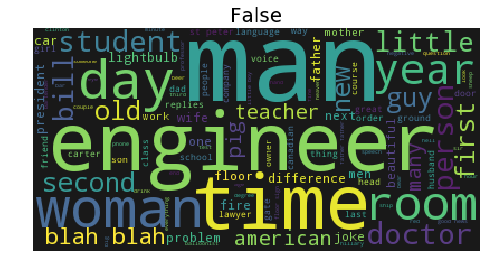

In [8]:
stopword=set(STOPWORDS)

def word_cloud(df, column,  label=False, bg='black',cmap='viridis'):
    df[column] = df[column].apply(lambda x:x.lower())
    df_word = df[column].apply(lambda x: word_tokenize(x)).values 
   
    t = np.asarray([j for i in range(len(df_word)) for j in df_word[i]])
    tagged = nltk.pos_tag(t)
    kk =(np.array([x[1] for x in tagged]) =='NN') | (np.array([x[1] for x in tagged]) =='JJ') | (np.array([x[1] for x in tagged]) =='NNP') | (np.array([x[1] for x in tagged]) =='NNS') | (np.array([x[1] for x in tagged]) =='NNPS')
    total = t[kk]
    
    wc= WordCloud(collocations=True,background_color=bg,max_words=2000,stopwords=stopword)
    wc.generate(" ".join(total))

    plt.figure(figsize=(8,8))
    plt.axis("off")
    plt.title(label, fontsize=20) #'
    plt.imshow(wc.recolor(colormap= cmap , random_state=17), alpha=0.9)
    plt.show()
    
    return(wc)

total=word_cloud(data,'contents')

The most frequent words are "man" "engineer" "day" "time" "woman" "room" "doctor"... etc. Most of words seem not to have specific meaning for the joke. 

### 5. Tf-idf and document similarity

In [9]:
stopwords = nltk.corpus.stopwords.words('english')
stemmer = SnowballStemmer("english")

def tokenize_and_stem(text):
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

## TFIDF
tfidf_vectorizer = TfidfVectorizer(max_features=200000, stop_words='english',
                              use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

tfidf_matrix = tfidf_vectorizer.fit_transform(data.contents) #fit the vectorizer to synopses
print(tfidf_matrix.shape)

terms = tfidf_vectorizer.get_feature_names()
cosine_sim = cosine_similarity(tfidf_matrix)
dist = 1 - cosine_sim

(139, 9888)


Now plot the similarity scores for the jokes to each other. THe dark blue means no significant similarity, but some lighter blue/green indicates some similarity.

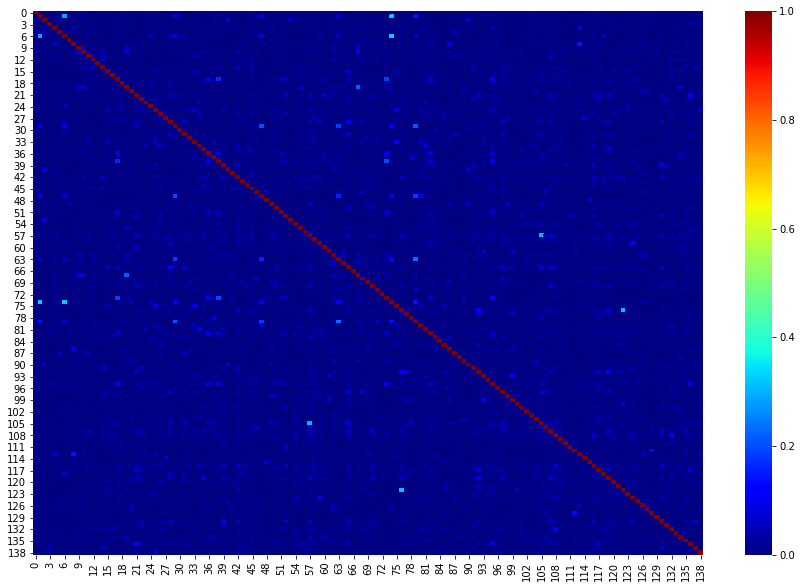

In [10]:
plt.figure(figsize=(15,10))
sns.heatmap(cosine_sim,cmap='jet')

### 6. Visualizing document clusters¶

Along with the similarity plot we just saw, we plot the hierarchical clustering of these jokes using the dendrogram library.

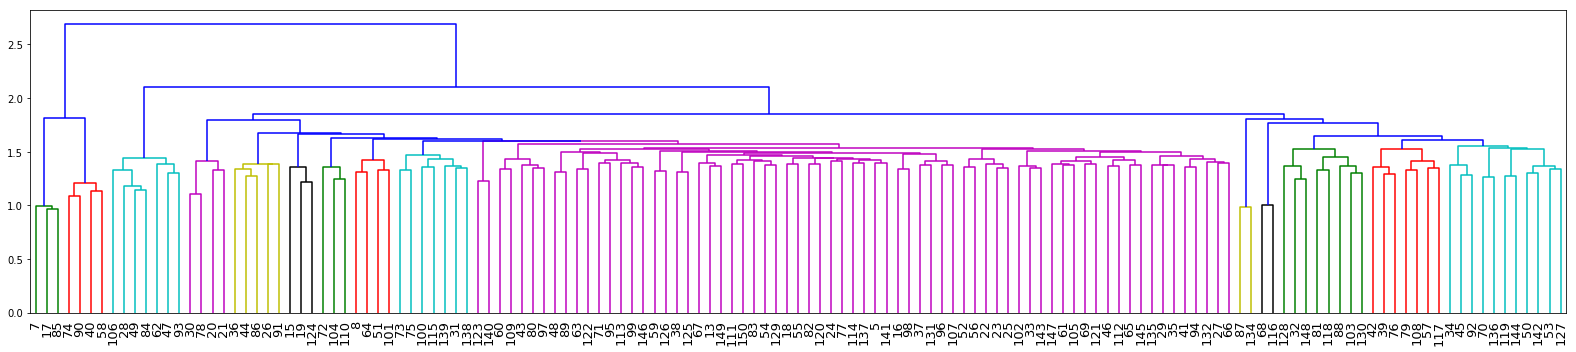

In [11]:
linkage_matrix = ward(dist)
fig, ax = plt.subplots(figsize=(22, 5)) 
ax = dendrogram(linkage_matrix, orientation="top", labels=data.Num.values, leaf_font_size=13,
               color_threshold=1.6);

plt.tick_params(axis='y', which='both')
plt.tight_layout() 
plt.show()

The dendrogram above has distinct clusters of jokes, grouped by similarity scores, shown in separate colors. Some of these clusters correspond to a particular style of joke that they share, while others are merely grouped together because of one or more words they have in common. Here are a few examples:

 - "Lightbulb" jokes: the two groups on the far left that are green and red all correspond to the classic "lightbulb" joke, with the three in the green subcluster having the setup of: "How many [blank] does it take to screw in a lightbulb?", while the nearby red sub-cluster have the setup: "How many [blank] does it take to change a lightbulb?". 


 - Engineer jokes: the jokes in the teal-colored cluster on the far left all involve engineers. The style of jokes varies, but they all have engineers featured in the joke.


 - "What's the difference between" jokes: The purple-colored cluster on the far left consists of jokes of a particular style that derives humor by contrasting two things and offering a snide commentary on one of those things. For example: "q: what's the difference between the government and the mafia? a: one of them is organized."


 - College-level school settings: jokes that reference professors, students, tests, and dorms ended up grouped together in a cluster. Although the punchlines were quite different, the similar settings were enough to be clustered together because of the similarity in the words being used.

### 7. Best Joke vs. Worst Joke

What are the highest- and lowest-rated jokes in this sample?

In [12]:
new_rating = rating.merge(data, left_on='Num', right_on='Num', how='left')
df = new_rating.groupby('Num').median()['rating'].reset_index()
new = df.merge(data, left_on='Num', right_on='Num', how='left')
new = new.sort_values('rating')
new = new.reset_index()

In [13]:
print('====================================================================================================')
print('The best joke is : ')
print(new.iloc[-1].contents)
print('====================================================================================================')
print('The worst joke is : ')
print(new.iloc[0].contents)

The best joke is : 
89:a radio conversation between a us naval ship and canadian authorities...americans: please divert your course 15 degrees to the north to avoid a collision.canadians: recommend you divert your course 15 degrees to the south to avoid a collision.americans: this is the captain of a us navy ship. i say again, divert your course.canadians: no. i say again, you divert your course.americans: this is the aircraft carrier uss lincoln, the second largest ship in the united states' atlantic fleet. we are accompanied by three destroyers, three cruisers and numerous support vessels. i demand that you change your course 15 degrees north, that's one five degrees north, or counter-measures will be undertaken to ensure the safety of this ship.canadians: this is a lighthouse. your call.
The worst joke is : 
141:jack bauer can get mcdonald's breakfast after 10:30.


### 8. Bokeh Plot

Now make a plot that shows the jokes ranked by rating, from best-to-worst. By using Bokeh, I can make it an interactive plot that shows the joke when you hover the mouse over each joke. Below I show two of these plots, the first showing a ranked list of the jokes with a positive median rating and then a ranked list of the jokes with a negative median rating. If you cannot see the bokeh plot below, click [here](pos.html) for the plot with jokes with positive mean ratings, or click [here](neg.html) for one with negative mean ratings. 

In [14]:
pos = new[new.rating >= 0]
neg = new[new.rating < 0]
neg.rating= neg.rating* (-1)

/Users/ryan/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [15]:
output_file('pos.html')
source = ColumnDataSource(pos)
p = figure(plot_width=800, plot_height=1000, 
           title="Median Rating (Sorted by rating) - positive", 
           toolbar_location=None, 
           tools="",
           x_range=[0,10])
p.xgrid.grid_line_color = None
p.xaxis.axis_label = "Positive Rating"
p.xaxis.major_label_orientation = 1.2

p.hbar(y='index', right='rating', height=1.1, source=source, fill_color='#2b83ba',
       line_color="white",hover_fill_color='#ffffbf')

#p.add_tools(HoverTool(tooltips=[("Contents", "@contents"),("Rating","@rating")]))
p.add_tools(HoverTool(tooltips = """
    Rating: @rating <br />
    <div>
      @contents
    </div>
"""))
show(p)

In the plot above, the highest-rated joke (based on median scores) is at the top.

In [16]:
output_file('neg.html')
source = ColumnDataSource(neg)
p = figure(plot_width=900, plot_height=200, 
           title="Median Rating (Sorted by rating) - negative", 
           toolbar_location=None, 
           tools="",
           x_range=[0,10])

p.xgrid.grid_line_color = None
p.xaxis.axis_label = "Negative Rating"
p.xaxis.major_label_orientation = 1.2

p.hbar(y='index', right='rating', height=1.1, source=source, fill_color='#EF4566',
       line_color="white",hover_fill_color='#ffffbf')

#p.add_tools(HoverTool(tooltips=[("Contents", "@contents"),("Rating","@rating")]))
p.add_tools(HoverTool(tooltips = """
    Rating: @rating <br />
    <div>
      @contents
    </div>
"""))
show(p)

In the plot above, the lowest-rated joke (based on median scores) is at the bottom.

### Conclusion

We have performed an analysis of the Jester dataset of jokes using TF-IDF and similarity scores to study distinct groups of jokes that emerge. In some cases, there are meaningful clusters of similar types of jokes, but in other cases jokes are clustered simply due to a couple words they have in common. We need to use better algorithms to cluster jokes, because jokes are more than just the sum of their parts. They are very subjective and rely on hidden meanings, puns, and pop culture references that are not accessible to standard Natural Language processing approaches. Therefore, do you have any better ideas for tackling this problem? :-)